In [8]:
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst, wf_from_files, WfType
from invisible_cities.core.core_functions import in_range
from invisible_cities.database  import load_db
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_interactions import ioff, panhandler, zoom_factory
# from ipywidgets import interact, IntSlider
# import ipywidgets as widgets
from scipy.signal import find_peaks
# from scipy.signal import wiener
# from scipy.signal import butter, filtfilt
from pathlib  import Path
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import sys
from datetime import datetime
from scipy.stats import trim_mean


In [2]:
def find_highest_wf(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]
    wfs[16] = np.arange(wfs[16] .size) * 0
    index = np.argmax(np.max(wfs, axis=1))
    print(index)
    return wfs[index]

def find_highest_sipm(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]
    index = np.argmax(np.max(wfs, axis=1))
    print(index)
    return index

In [382]:
def sum_wf1(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]

    element_wise_sum = np.zeros_like(wfs[0],dtype=np.int64)

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += array

    return element_wise_sum

def sum_wf(wfs):
    element_wise_sum = np.zeros_like(wfs[0])

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += array

    return element_wise_sum

def ADC_to_PE(wfs, datapmt):
    conv_factors = datapmt.adc_to_pes.to_numpy()

    for w in range(0, len(wfs)):
        if (conv_factors[w] == 1e5):
             wfs[w] = wfs[w]*0
        else:
            wfs[w] = wfs[w]/conv_factors[w]

    return wfs


def check_summed_baseline(wfs_sum, grass_lim, S1_height):

    flag=False
    tc=25e-3
    
    # Check the baseline at the end and start match
    # otherwise there could be signal there so the baseline is all messed up
    num_samples = int(25/tc)
    baseline1=np.mean(wfs_sum[-num_samples:])
    baseline2=np.mean(wfs_sum[0:int(25/tc)])

    # Check if the baseline varies by more than 0.1 PE
    if (abs(baseline1-baseline2) > 0.2):
        print("Error in baselines at start and end, dropping event")
        print(baseline1-baseline2)
        flag = True

    # Look in the window for large peaks that could be other S1/S2 pulses. 
    # This will mess up the reconstruction
    peaks, _ = find_peaks(wfs_sum[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=S1_height, distance=30/tc)

    bin_fact=100 # rebin amount
    wfs_sum_binned = rebin_array(wfs_sum, bin_fact)
    peaks_rebin, _ = find_peaks(wfs_sum_binned[ int(grass_lim[0]/(tc*bin_fact)):int(grass_lim[1]/(tc*bin_fact))], height=0.6)
    peaks_rebin = peaks_rebin*bin_fact

    peaks_filt = np.append(peaks, peaks_rebin)

    return flag, peaks_filt

def get_PEs_inWindow(times, wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, window):

    df = []

    tsel_     = in_range(times, *window)
    wfs = wfs[:, tsel_]

    for pmt_no, wf in enumerate(wfs):

        idx_over_thr = np.argwhere(wf > noise[pmt_no]).flatten()
        splits       = np.argwhere(np.diff(idx_over_thr) > thr_split).flatten()
        idx_slices   = np.split(idx_over_thr, splits+1)
        idx_slices   = list(filter(lambda sl: in_range(len(sl), peak_minlen, peak_maxlen + .5), idx_slices))

        for sl in idx_slices:
            m = np.argmax(wf[sl]) + sl[0]
            pe_int = wf[m-half_window:m+half_window].sum()*tc
            df.append(pd.DataFrame(dict(event = evt_info[evt_no][0], ts_raw=ts/1e3, pmt=pmt_no, pe_int=pe_int, peak_time=m*tc+grass_lim[0], noise_thr=noise[pmt_no]), index=[0]))

    return df


def CorrectRawBaseline(wfs):

    corrected_waveforms = []

    for wfm in wfs:
        num_samples = int(25/tc)
        baseline1=np.mean(wfm[-num_samples:])
        baseline2=np.mean(wfm[0:int(25/tc)])
        wfm = -1*(wfm-baseline2)
        corrected_waveforms.append(wfm)

    return np.array(corrected_waveforms)


def find_fwhm(time, amplitude):
    max_amplitude = np.max(amplitude)
    half_max = max_amplitude / 2

    # Find indices where amplitude crosses half-maximum level
    above_half_max = np.where(amplitude >= half_max)[0]

    # First crossing point
    left_idx = above_half_max[0]
    right_idx = above_half_max[-1]

    # Interpolate to get more accurate crossing times
    t_left = np.interp(half_max, [amplitude[left_idx-1], amplitude[left_idx]], [time[left_idx-1], time[left_idx]])
    t_right = np.interp(half_max, [amplitude[right_idx], amplitude[right_idx+1]], [time[right_idx], time[right_idx+1]])

    fwhm = t_right - t_left
    return fwhm, max_amplitude


def GetBaselineInterp(times, wfs):

    interps = []
    for pmt_no, wf in enumerate(wfs):

        # Apply trimmed mean over a sliding window
        window_size = 100  # Adjust as needed
        trim_ratio = 0.4  # Trim 10% from each side

        trimmed_wfm = np.array([
            trim_mean(wf[i:i+window_size], proportiontocut=trim_ratio) 
            for i in range(0, len(wf), window_size)
        ])

        # Downsample the time array to match the trimmed values
        trimmed_times = times[::window_size]

        # Interpolate the smoothed data
        interp_func = interp1d(trimmed_times, trimmed_wfm, kind='cubic', bounds_error=False, fill_value=0)  # Cubic interpolation for smoothness
        interps.append(interp_func)

    return interps

# Uses the interpolation in a range to fix the baseline
def CorrectDeconvBaseline(t_pmt, tmin, tmax, interps, wfs):
    
    for pmt_no, wf in enumerate(wfs):
        # Apply the interpolation function to waveform time points
        amplitude_interpolated = interps[pmt_no](t_pmt)
        mask = (t_pmt < tmin) | (t_pmt > tmax)
        amplitude_interpolated[mask] = 0

        # Subtract the interpolated amplitude from the waveform amplitude
        wfs[pmt_no] = wf - amplitude_interpolated

    return wfs

# Fit the distribution 
def Gaussian(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

def FitS2(time, amplitude):
    max_amplitude = np.max(amplitude)
    half_max = max_amplitude / 2

    # Find indices where amplitude crosses half-maximum level
    above_half_max = np.where(amplitude >= half_max)[0]

    time_slice = time[above_half_max]
    # print(time_slice)
    

    # Perform the curve fit
    params, covariance = curve_fit(Gaussian, time[above_half_max], amplitude[above_half_max], bounds = ([1, min(time_slice),1], [1e6, max(time_slice),100]))

    # Extract the fitted parameters
    A, mu, sigma = params
    print(A, mu, sigma )

    return A, mu, sigma


def GetInterpParams(interps, grass_lim):
    interp_amp = np.array([])
    for interp in interps:
        interp_amp = np.append(interp_amp, interp(grass_lim[0]))

    mean_interp_amp=np.mean(interp_amp)
    std_interp_amp = np.std(interp_amp)

    return mean_interp_amp, std_interp_amp

# Rebin a waveform
def rebin_array(arr, bin_size):
    new_len = len(arr) // bin_size  # Ensure integer division
    return np.mean(arr[:new_len * bin_size].reshape(new_len, bin_size), axis=1)


In [385]:
# filename  = "../data/run_13852_0000_ldc1_trg0.waveforms.h5"
# filename  = "../data/run_13859_0000_ldc1_trg0.waveforms.h5"
# filename  = "../data/run_14180_0049_ldc6_trg0.waveforms.h5" 
# filename  = "../data/run_14584_0000_ldc1_trg0.waveforms.h5"
# filename  = "../data/xenon/run_14498_0011_ldc3_trg0.waveforms.h5"
# filename = "../data/run_14583_0000_ldc1_trg0.waveforms.h5"
# filename = "../data/run_14710_0000_ldc7_trg0.waveforms.h5"
filename = "../data/run_14780_0108_ldc1_trg0.waveforms.h5"

raw_evts = pd.read_hdf(filename, '/Run/events')
print(raw_evts.evt_number.unique())

raw_evts = load_dst(filename, 'Run', 'events')
nrwfs = len(raw_evts.evt_number.unique())
print("Number of Waveforms:", nrwfs)


[47630 47637 47644 47651 47658 47665 47672 47679 47686 47693 47700 47707
 47714 47721 47728 47735 47742 47749 47756 47763 47770 47777 47784 47791
 47798 47805 47812 47819 47826 47833 47840 47847 47854 47861 47868 47875
 47882 47889 47896 47903 47910 47917 47924 47931 47938 47945 47952 47959
 47966 47973 47980 47987 47994 48001 48008 48015 48022 48029 48036 48043
 48050 48057 48064]
Number of Waveforms: 63


In [386]:
# Load in the database for SiPMs

# RUN_NUMBER = 13852
# RUN_NUMBER=13859
# RUN_NUMBER = 14180
# RUN_NUMBER = 14498
# RUN_NUMBER = 14584
# RUN_NUMBER = 14583
# RUN_NUMBER = 14710
RUN_NUMBER = 14780

deconv = deconv_pmt("next100", RUN_NUMBER, 62400)

detector_db = "next100"
datasipm = load_db.DataSiPM(detector_db, RUN_NUMBER)
datapmt = load_db.DataPMT(detector_db, RUN_NUMBER)


# display(datasipm)


# display(datapmt)

thr_split   = 2      # maximum number of samples allowed to be below threshold to consider it a peak
peak_minlen = 2      # minimum number of samples above threshold in a peak
peak_maxlen = 10     # maximum number of samples above threshold in a peak
half_window = 4      # number of samples to each side of a peak maximum to integrate
tc          = 25e-3  # constant to convert from samples to time or vice versa. 
noise_sigma = 4      # how many STD above noise for the single PEs to be

dead_pmts = [3, 16, 24, 36, 37, 38, 39,40, 41, 48, 53, 58]

if (RUN_NUMBER == 13850 or RUN_NUMBER == 13852 or RUN_NUMBER == 13859):
    grass_lim   = 1050, 1770 # time window in mus in which to search for single pes
    noise_lim   = 1900, 2000 # time window to calculate the noise baseline
    S1_height   = 10
    S2_height   = 10
    S2_start    = 990        # S2 integration window start
    S2_end      = 1040       # S2 integration window end
    cath_lim    = 1785, 1860 # start/end window for cathode events
    S1_window   = 100, 985   # window to search for S1
    S2_window   = 985, 1200  # window to search for S2

elif (RUN_NUMBER == 14180):
    grass_lim   = 1050, 1770 
    noise_lim   = 1900, 2000 
    S1_height   = 10
    S2_height   = 10
    S2_start    = 990
    S2_end      = 1040
    cath_lim    = 1785, 1860 
    S1_window   = 100, 985
    S2_window   = 985, 1200 

elif (RUN_NUMBER == 14498):
    grass_lim   = 1650, 2350
    noise_lim   = 2500, 2600
    S1_height   = 4
    S2_height   = 8
    S2_start    = 1590
    S2_end      = 1640
    cath_lim    = 2500, 2550 
    S1_window   = 100, 1585
    S2_window   = 1585, 1800 

elif (RUN_NUMBER == 14584 or RUN_NUMBER == 14583): # 20 kV
    grass_lim   = 1650, 2350
    noise_lim   = 3100, 3200
    S1_height   = 4
    S2_height   = 8
    S2_start    = 1590
    S2_end      = 1640
    cath_lim    = 3014, 3064
    S1_window   = 100, 1585
    S2_window   = 1585, 1800 

elif (RUN_NUMBER == 14710): # 20 kV
    grass_lim   = 1050, 1770
    noise_lim   = 3100, 3200
    S1_height   = 4
    S2_height   = 8
    S2_start    = 1590
    S2_end      = 1640
    cath_lim    = 3014, 3064
    S1_window   = 100, 1585
    S2_window   = 1585, 1800 


elif (RUN_NUMBER == 14780): 
    grass_lim   = 1650, 2350
    noise_lim   = 2500, 2600
    S1_height   = 4
    S2_height   = 8
    S2_start    = 1590
    S2_end      = 1640
    cath_lim    = 2500, 2600
    S1_window   = 100, 1585
    S2_window   = 1585, 1800 


else:
    print("Unknown RUN Configured")


useRaw = False



On Event: 14 real ID: 47728
Waveform length: 48
1888
x,y: 73.175 -356.525
94.27470953929978 1615.6540139509143 34.141912000016156
Num Grass Peaks: 3


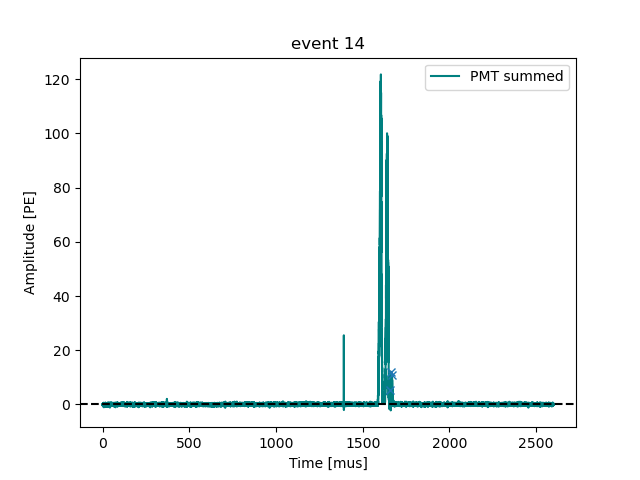

In [387]:
%matplotlib widget

event_number = 14

wf_sum_all_evts = 0

# highest = highest PMT waveform, "summed" = summed waveform across all PMT, "1-60" select PMT number for a specific pmt
# plot_mode = "highest"
plot_mode = "summed"
# plot_mode = 23



# Open the file
with tb.open_file(filename) as file:

    rwf      = file.root.RD.pmtrwf
    evt_info = file.root.Run.events

    # Loop over the events
    for evt_no, wfs in enumerate(rwf):
        
        if (evt_no != event_number):
            continue

        # if (evt_no > 45):
        #     break

        print("On Event:", evt_no, "real ID:", evt_info[evt_no][0])

        # Decide whether to use raw or deconvolved waveforms
        if ( useRaw):
            wfs = CorrectRawBaseline(wfs) # Function may need checking
        else:
            wfs = deconv(wfs)

        # Convert the ADC to PE
        wfs = ADC_to_PE(wfs, datapmt)

        print("Waveform length:", len(wfs))

        # Zero out the dead PMTs
        if (RUN_NUMBER != 14780):
            for pmt_ in dead_pmts:
                wfs[pmt_] = np.arange(wfs[pmt_] .size) * 0
        
        # Get the highest SiPM for X,Y positioning
        highest_sipm = find_highest_sipm(file.root.RD.sipmrwf, event_number)
        x_pos = datasipm.iloc[highest_sipm].X
        y_pos = datasipm.iloc[highest_sipm].Y
        print("x,y:", x_pos, y_pos)

        sp_pmt  = 25e-3 # sampling period in mus
        sp_sipm = 1     # sampling period in mus
        times   = np.arange(wfs[0] .size) * sp_pmt
        t_sipm  = np.arange(highest_sipm.size) * sp_sipm

        # Calculate the noise of the PMT
        noise = []
        for pmt_no, wf in enumerate(wfs):
            noise.append(noise_sigma*np.std(wf[int(noise_lim[0]/tc):int(noise_lim[1]/tc)]))

        # Interpolate the baseline
        interps = GetBaselineInterp(times, wfs)

        # Correct the waveforms in the band
        wfs = CorrectDeconvBaseline(times, grass_lim[0], noise_lim[1], interps, wfs) # Correct baseline to the end of the waveform

        # Choose which waveform to plot
        if (plot_mode == "highest"):
            index = np.argmax(np.max(wfs, axis=1))
            wf_pmt = wfs[index]
            plot_mode = index
            wfs_sum = sum_wf(wfs)
        elif (plot_mode == "summed"):
            wf_pmt =  sum_wf(wfs)
            wfs_sum  = wf_pmt
        else:
            wf_pmt = wfs[int(plot_mode)]
            wfs_sum = sum_wf(wfs)

        S1, _ = find_peaks(wfs_sum[ int(S1_window[0]/tc):int(S1_window[1]/tc)], height=S1_height, distance=10/tc)
        S2, _ = find_peaks(wfs_sum[ int(S2_window[0]/tc):int(S2_window[1]/tc)], height=S2_height, distance=50/tc)

        if (len(S1) ==0):
            print("No S1!")

        if (len(S2) ==0):
            print("No S2!")

        # Fit the S2 pulse
        A, mu, sigma = FitS2(times[int(S2_start/tc):int(S2_end/tc)], wf_pmt[int(S2_start/tc):int(S2_end/tc)])
        area = A * sigma * np.sqrt(2 * np.pi)

        new_time = np.arange( grass_lim[0],noise_lim[1],tc)
        
        if (plot_mode != "summed"):
            interpolated_amplitude = interps[plot_mode](new_time)

        plt.figure()
        plt.plot(times, wf_pmt , label = f"PMT {plot_mode}",  color = "Teal");
        plt.ylabel("Amplitude [PE]")
        plt.xlabel("Time [mus]")
        plt.axhline(y=0, color='black', linestyle='--')
        plt.legend(loc = "upper right")
        plt.title(f"event {evt_no}")

        # plt.plot(filtered_time, filtered_amplitude, 'o', label="Filtered Points", color="red")
        # plt.plot(filtered_time, smoothed_amplitude, label="Smoothed Line", color="blue")
        if (plot_mode != "summed" and plot_mode != "highest"):
            plt.plot(new_time, interpolated_amplitude, label="Interpolation", color="red")

            mean_interp_amp, std_interp_amp = GetInterpParams(interps, grass_lim)

        # plt.plot(new_time, Gaussian(new_time, A,mu,sigma), color="red")

        pass_flag, grass_peaks = check_summed_baseline(wfs_sum, grass_lim, S1_height)
        print("Num Grass Peaks:", len(grass_peaks))

        if (pass_flag):
            print("Event Failed Quality Control...")
            continue

        if (len(grass_peaks) > 0):
            plt.plot(times[grass_peaks+int(grass_lim[0]/25e-3)], wf_pmt[grass_peaks+int(grass_lim[0]/25e-3)], 'x', label='Peaks')

        # Check the baseline, if we got something really negative
        # then the deconvolution likely failed, so skip grass calculation
        min_baseline = min(wf_pmt[int((grass_lim[0]-50)/tc):int((grass_lim[0]+100)/tc)])
        if (min_baseline < -5):
            print("Problem with deconvolution", min_baseline)

        # plt.xlim(1020,1100)
        # plt.ylim(-100,200)
        # plt.semilogy()

        wf_sum_all_evts+=wf_pmt
        
        # plt.savefig(f"../plots/deconvolved/run_{RUN_NUMBER}_event{evt_no}.png")


31 0.1926644326514294
32 0.17496146434460436
42 0.17311130279944228


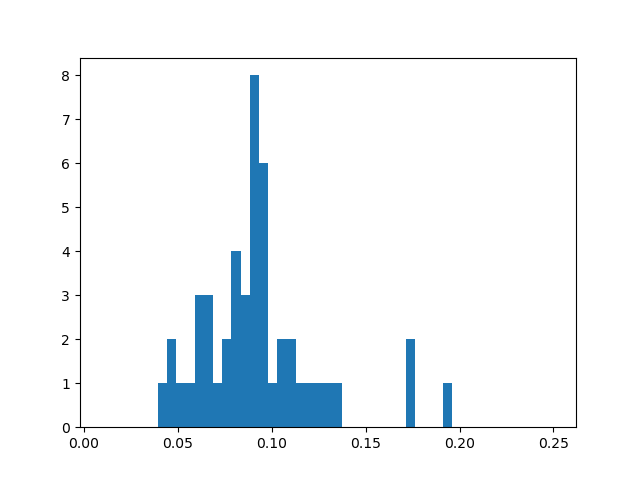

In [353]:
plt.figure()

plt.hist(noise, bins = np.linspace(0.01,0.25, 50));
for i,n in enumerate(noise):
    if (n>0.14):
        print(i, n)

[0.0000e+00 2.5000e+00 5.0000e+00 ... 2.5925e+03 2.5950e+03 2.5975e+03]
[]
Num Grass Long Peaks: 0
660 940 1040


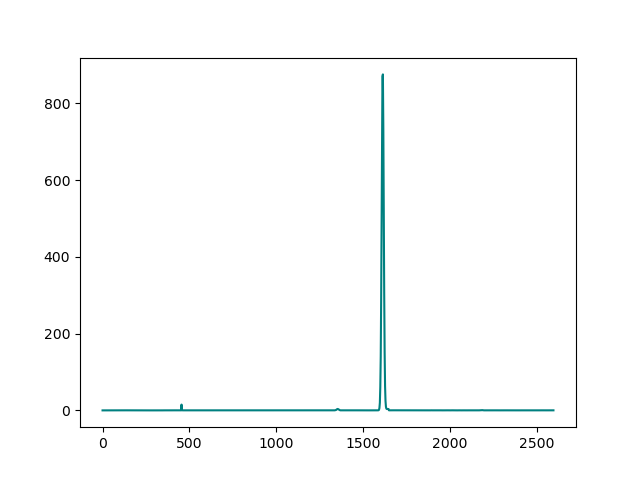

In [381]:
plt.figure()
bin_fact=100 # rebin amount
wfs_sum_binned = rebin_array(wfs_sum, bin_fact)
times_binned   = np.arange(wfs_sum_binned .size) * sp_pmt*bin_fact
print(times_binned)
plt.plot(times_binned, wfs_sum_binned , label = f"PMT {plot_mode}",  color = "Teal");

peaksN, _ = find_peaks(wfs_sum_binned[ int(grass_lim[0]/(tc*bin_fact)):int(grass_lim[1]/(tc*bin_fact))], height=1)

print( (peaksN + int(grass_lim[0]/(tc*bin_fact)))*bin_fact )

print("Num Grass Long Peaks:", len(peaksN))

print(int(grass_lim[0]/(tc*bin_fact)), int(grass_lim[1]/(tc*bin_fact)), len(times_binned))


[]

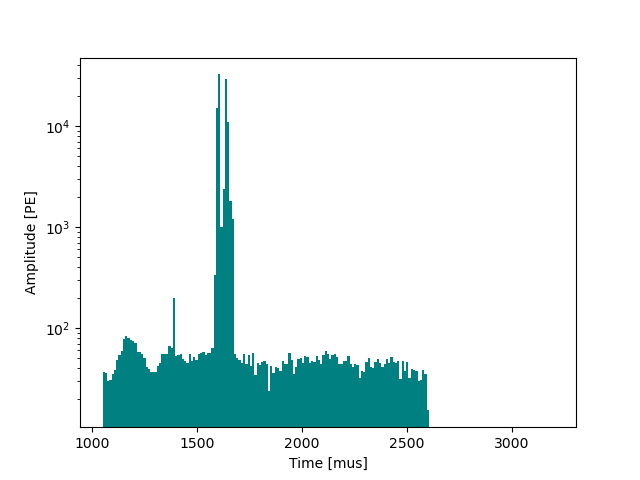

In [390]:
plt.figure()

mask = wf_pmt > 0

# plt.hist(times[mask], weights = wf_pmt[mask], bins = np.linspace(2500,3200,500));
# plt.hist(times[mask], weights = wf_pmt[mask], bins = np.linspace(1500,2000,20), color="Teal");

mask = wf_sum_all_evts>0
# plt.hist(times[mask], weights = wf_sum_all_evts[mask], bins = np.linspace(1050,2000,200), color="Teal");
plt.hist(times[mask], weights = wf_sum_all_evts[mask], bins = np.linspace(1050,3200,200), color="Teal");
plt.ylabel("Amplitude [PE]")
plt.xlabel("Time [mus]")
plt.semilogy()

In [388]:


folder_out = Path("../data/analysis/")


wf_sum = 0
wf_sum_clean = 0

data = []
data_properties = []
noise_df = []
with tb.open_file(filename) as file:
    file_no=0
    evt_info = file.root.Run.events
    rwf      = file.root.RD.pmtrwf
    time     = np.arange(rwf.shape[2]) * tc
    tsel     = in_range(time, *grass_lim)
    for evt_no, wfs in enumerate(rwf):

        print("\n\nOn Event:", evt_no, "real ID:", evt_info[evt_no][0])

        # if (evt_no != 3):
        #     continue

        # if (evt_no > 1): continue

        highest_sipm = find_highest_sipm(file.root.RD.sipmrwf, evt_no)
        x_pos = datasipm.iloc[highest_sipm].X
        y_pos = datasipm.iloc[highest_sipm].Y

        _, ts = evt_info[evt_no]
        
        if ( useRaw):
            wfs = CorrectRawBaseline(wfs)
        else:
            wfs = deconv(wfs)

        # Convert the ADC to PE
        wfs = ADC_to_PE(wfs, datapmt)

       # Zero out the dead PMTs
        if (RUN_NUMBER != 14780):
            for pmt_ in dead_pmts:
                wfs[pmt_] = np.arange(wfs[pmt_] .size) * 0
        
        wfs_sum = sum_wf(wfs)

        times   = np.arange(wfs_sum .size) * tc # sampling period in mus

        S1, _ = find_peaks(wfs_sum[ int(S1_window[0]/tc):int(S1_window[1]/tc)], height=S1_height, distance=10/tc)
        S2, _ = find_peaks(wfs_sum[ int(S2_window[0]/tc):int(S2_window[1]/tc)], height=S2_height, distance=50/tc)

        if (len(S1) ==0):
            print("No S1!")

        if (len(S2) ==0):
            print("No S2!")

        if (len(S1) !=1 or len(S2)!=1 ):
            deltaT = -999
        else:
            deltaT = S2[0]*tc+S2_window[0] - (S1[0]*tc+S1_window[0])
            # print("Time difference between S1 and S2:", deltaT)

        # Calcilate the noise of the PMT
        noise = []
        for pmt_no, wf in enumerate(wfs):
            noise.append(noise_sigma*np.std(wf[int(noise_lim[0]/tc):int(noise_lim[1]/tc)]))

        interps = GetBaselineInterp(times, wfs)

        # Correct the waveforms
        wfs = CorrectDeconvBaseline(times, grass_lim[0], noise_lim[1], interps, wfs) # Correct baseline up to the end of pulsw

        mean_interp_amp, std_interp_amp = GetInterpParams(interps, grass_lim)

        # wf_sum_clean+=wfs_sum

        wfs_sum_cor = sum_wf(wfs)
        wf_sum_clean+=wfs_sum_cor

        # Check if event failed the quality control, use corrected waveform
        pass_flag, grass_peaks = check_summed_baseline(wfs_sum_cor, grass_lim, S1_height)
        if (pass_flag):
            print("Event Failed Quality Control...")
            continue

        print("Num Grass Peaks:", len(grass_peaks))

        
        peaks2, _ = find_peaks(wfs_sum[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=4, width=0.5/tc)
        # if (len(grass_peaks) < 0 and len(peaks2) < 1):
        #     wfs_sum_cor = sum_wf(wfs)
        #     wf_sum_clean+=wfs_sum_cor


        # Sum values in the peak up to the point where the pulse goes to zero
        S2_area = wfs_sum[int(S2_start/tc):int(S2_end/tc)]
        S2_area = S2_area[S2_area > 0].sum()*tc

        try:
            FWHM, S2_amplitude = find_fwhm(times[int(S2_start/tc):int(S2_end/tc)], 
                                        wfs_sum[int(S2_start/tc):int(S2_end/tc)])
        except:
            print("Error on FWHM calculation, skipping")
            continue # Continue without interruption
        
        A, mu, sigma = FitS2(times[int(S2_start/tc):int(S2_end/tc)], wfs_sum[int(S2_start/tc):int(S2_end/tc)])
        area = A * sigma * np.sqrt(2 * np.pi)

        print("S2 times are:", mu, S2[0]*tc+S2_window[0])
        print("Sigma is: ", FWHM/2.355, sigma)

        cath_df = get_PEs_inWindow(times, wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, cath_lim)
        cath_df = pd.concat(cath_df, ignore_index=True)
        # display(cath_df[cath_df.pmt == 1])
        cath_area = cath_df.pe_int.sum()*tc
        cath_time = cath_df.peak_time.mean()
        cath_std = cath_df.peak_time.std()
        
        data_properties.append(pd.DataFrame(dict(event = evt_info[evt_no][0], S2_area=S2_area, S2_areafit=area,S2_time = mu, cath_area=cath_area,cath_time=cath_time,cath_std=cath_std, ts_raw=ts/1e3, deltaT=deltaT, sigma = FWHM/2.355, x = x_pos, y = y_pos, grass_peaks = len(grass_peaks), nS1 = len(S1), mean_interp_amp= mean_interp_amp, std_interp_amp=std_interp_amp), index=[0]))

        # Check the baseline, if we got something really negative
        # then the deconvolution likely failed, so skip grass calculation
        min_baseline = min(wfs_sum_cor[int((grass_lim[0]-50)/tc):int((grass_lim[0]+100)/tc)])
        if (min_baseline > -5):
            df = get_PEs_inWindow(times, wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, grass_lim)
            data = data + df
        else:
            print("Problem with deconvolution", min_baseline)

        # now add a search window in the first 100mus to understand the background
        if (len(S1)== 0):
            noise_range = 0,500
        else:
            noise_range = 0, S1[0]*tc+S1_window[0]-10
        print("Noise range is:", noise_range[1])
        
        noise_df_temp = get_PEs_inWindow(times, wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, noise_range)
        noise_df = noise_df + noise_df_temp


    data = pd.concat(data, ignore_index=True)
    data = data.assign(ts = np.array(list(map(datetime.fromtimestamp, data.ts_raw))))
    # data.to_hdf(file_out, "/data", complib="zlib", complevel=4, mode="w")
    noise_df = pd.concat(noise_df, ignore_index=True)

    data_properties = pd.concat(data_properties, ignore_index=True)
    data_properties = data_properties.assign(ts = np.array(list(map(datetime.fromtimestamp, data_properties.ts_raw))))





On Event: 0 real ID: 47630
685
Num Grass Peaks: 0
1236.0939626633983 1616.122918218222 6.8564072546121215
S2 times are: 1616.122918218222 1615.6
Sigma is:  6.592370050738632 6.8564072546121215
Noise range is: 260.725


On Event: 1 real ID: 47637
977
Num Grass Peaks: 0
94.51825379762559 1602.6286779723673 4.0091842915874025
S2 times are: 1602.6286779723673 1602.85
Sigma is:  3.4579425628729017 4.0091842915874025
Noise range is: 1180.375


On Event: 2 real ID: 47644
2575
Num Grass Peaks: 0
188.3825327887355 1606.1846212189892 3.7556418241658527
S2 times are: 1606.1846212189892 1605.9
Sigma is:  3.6955872387342774 3.7556418241658527
Noise range is: 1465.6000000000001


On Event: 3 real ID: 47651
2058
Num Grass Peaks: 1
1729.4475324860794 1618.2510535564215 7.133476181083933
S2 times are: 1618.2510535564215 1617.5
Sigma is:  7.220592130097101 7.133476181083933
Noise range is: 264.05


On Event: 4 real ID: 47658
1624
Num Grass Peaks: 1
1555.0428605875247 1616.283156122351 6.31617892058788

In [370]:
display(data)
display(data_properties)
display(noise_df)

,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,4550,1.730123e+09,0,0.032626,1656.350,0.093006,2024-10-28 08:47:33.196
1,4550,1.730123e+09,0,0.044119,1698.325,0.093006,2024-10-28 08:47:33.196
2,4550,1.730123e+09,0,0.014564,1792.500,0.093006,2024-10-28 08:47:33.196
3,4550,1.730123e+09,0,0.046954,2125.500,0.093006,2024-10-28 08:47:33.196
4,4550,1.730123e+09,0,0.044211,2197.250,0.093006,2024-10-28 08:47:33.196
...,...,...,...,...,...,...,...
49495,4956,1.730123e+09,59,0.024986,1917.275,0.110232,2024-10-28 08:47:48.250
49496,4956,1.730123e+09,59,0.031509,2022.325,0.110232,2024-10-28 08:47:48.250
49497,4956,1.730123e+09,59,0.019574,2235.475,0.110232,2024-10-28 08:47:48.250
49498,4956,1.730123e+09,59,0.025763,2242.875,0.110232,2024-10-28 08:47:48.250


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,x,y,grass_peaks,nS1,mean_interp_amp,std_interp_amp,ts
0,4550,11427.190415,11330.178276,1610.963477,0.004010,1673.045000,19.589956,1.730123e+09,700.500,4.686574,-96.875,-294.325,0,1,0.044647,0.069784,2024-10-28 08:47:33.196
1,4557,11929.507685,11825.372609,1608.753465,0.001300,1664.750000,6.540738,1.730123e+09,361.275,3.461164,335.525,60.825,0,1,0.037790,0.056399,2024-10-28 08:47:33.375
2,4564,13765.218614,13768.689411,1610.330191,-0.000550,1674.946429,13.522870,1.730123e+09,392.625,3.890157,-126.975,-63.075,0,1,0.044556,0.083959,2024-10-28 08:47:33.626
3,4571,9777.348417,9804.116097,1613.951019,0.011349,1670.665476,12.007806,1.730123e+09,1233.700,6.111860,104.275,414.975,0,1,0.047828,0.089177,2024-10-28 08:47:33.869
4,4578,11365.309884,11428.874499,1609.418546,0.010132,1676.561765,16.661216,1.730123e+09,329.675,3.189057,-96.875,-294.325,0,1,0.035432,0.054053,2024-10-28 08:47:34.080
5,4585,12017.207227,12088.520570,1614.239575,0.005685,1676.747222,11.383688,1.730123e+09,-999.000,6.159431,319.975,-171.425,0,5,0.056949,0.123934,2024-10-28 08:47:34.249
6,4592,4561.604203,4511.583538,1612.066112,0.004426,1681.772917,14.646309,1.730123e+09,-999.000,6.106915,427.825,106.475,0,5,0.021826,0.017270,2024-10-28 08:47:34.634
7,4599,12599.410443,12521.979303,1614.687483,0.016758,1677.876000,12.641873,1.730123e+09,1217.900,6.234704,304.425,214.325,0,1,0.055351,0.136210,2024-10-28 08:47:34.839
8,4606,12070.934305,12079.691403,1608.381426,0.015460,1674.788636,10.566596,1.730123e+09,-999.000,2.898715,165.475,276.025,2,2,0.030090,0.055524,2024-10-28 08:47:35.090
9,4613,11693.099186,11648.099145,1613.278101,0.006063,1662.005882,8.728838,1.730123e+09,1125.850,5.862024,-281.475,184.225,0,1,0.050351,0.109658,2024-10-28 08:47:35.396


,event,ts_raw,pmt,pe_int,peak_time,noise_thr
0,4550,1.730123e+09,1,0.009083,2198.600,0.147619
1,4550,1.730123e+09,1,0.003190,2346.025,0.147619
2,4550,1.730123e+09,2,-0.001726,1679.000,0.105738
3,4550,1.730123e+09,2,0.000780,1812.100,0.105738
4,4550,1.730123e+09,2,0.001407,1914.150,0.105738
...,...,...,...,...,...,...
9164,4956,1.730123e+09,50,-0.030158,2196.200,1.073476
9165,4956,1.730123e+09,50,-0.027719,2255.125,1.073476
9166,4956,1.730123e+09,59,0.023918,1727.575,0.110232
9167,4956,1.730123e+09,59,0.032810,2060.100,0.110232


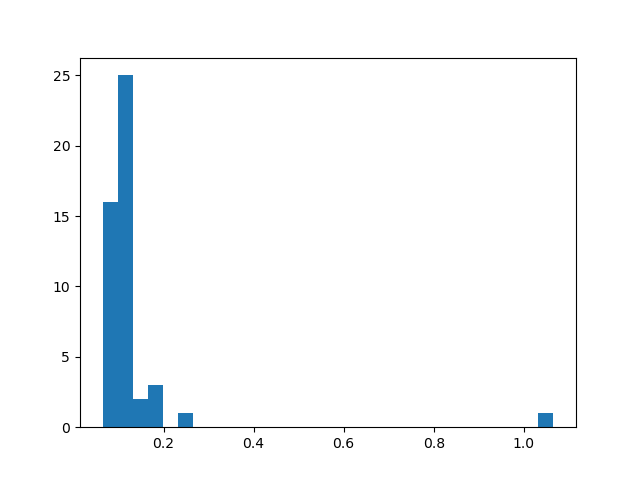

In [371]:
plt.figure()


# Remove duplicate (event, pmt) pairs
df_unique = data.drop_duplicates(subset=['event', 'pmt'])

# Compute mean noise_thr for each PMT across all events
result = df_unique.groupby('pmt')['noise_thr'].mean().reset_index()


plt.hist(result.noise_thr, bins = 30);

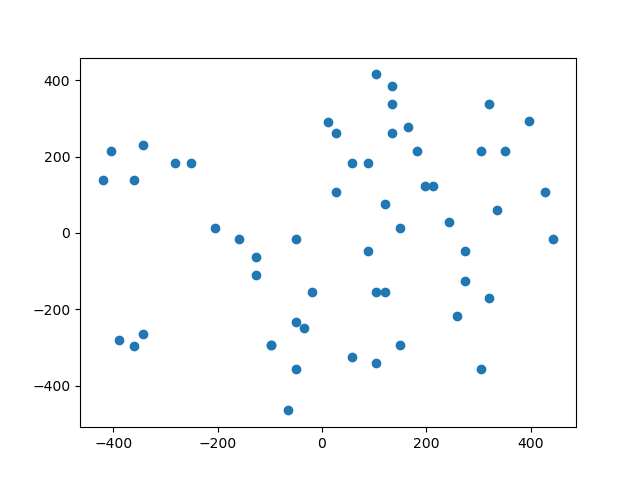

In [372]:
plt.figure()

plt.scatter(data_properties.x, data_properties.y)

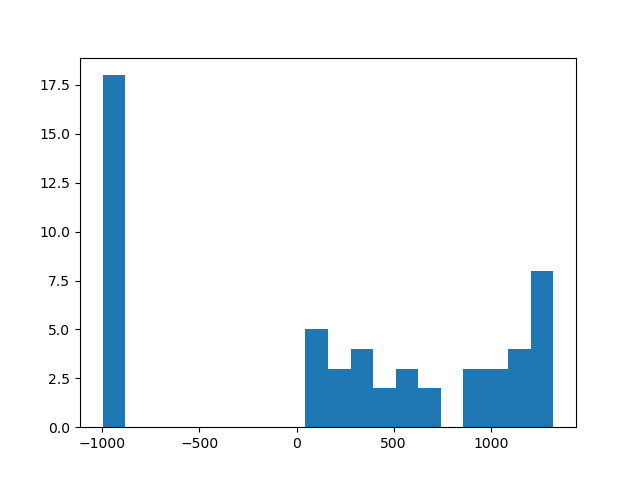

In [373]:
plt.figure()
plt.hist(data_properties.deltaT, bins = 20);

,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,x,y,grass_peaks,nS1,mean_interp_amp,std_interp_amp,ts


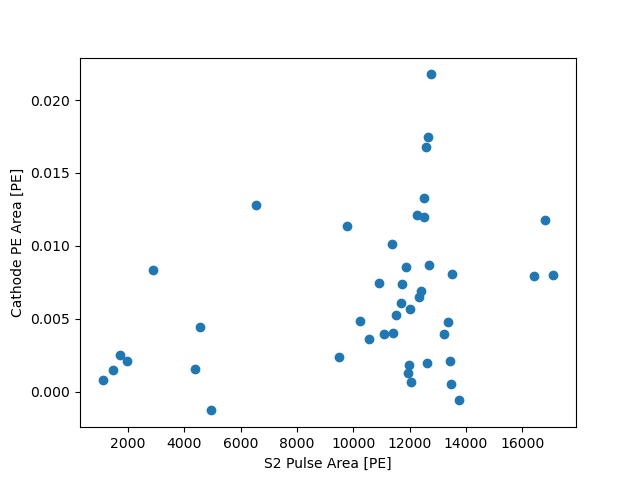

In [374]:
plt.figure()

prop_filt = data_properties[data_properties.grass_peaks == 0]

plt.scatter(prop_filt.S2_area, prop_filt.cath_area)
plt.xlabel("S2 Pulse Area [PE]")
plt.ylabel("Cathode PE Area [PE]")

display(data_properties[data_properties.cath_area > 1.25e7])

[1893.925 1895.45  1941.7   2078.7   2178.9   2180.75 ]


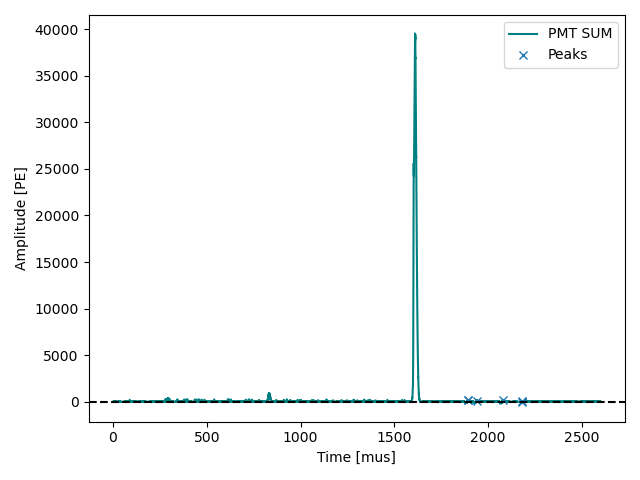

In [375]:
plt.figure()
t_pmt   = np.arange(wf_sum_clean .size) * 25e-3 # sampling period in mus
plt.plot(t_pmt , wf_sum_clean, label = "PMT SUM", color = "Teal");

# peaks, _ = find_peaks(wf_sum_clean[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=noise[6], distance=0.3/tc)
peaks, _ = find_peaks(wf_sum_clean[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=8, width=0.5/tc)
print(peaks*tc+grass_lim[0])

# peaks, _ = find_peaks(wf_sum_clean[ int(100/tc):int(985/tc)], height=10000, distance=40/tc)
# print(peaks*tc+100)

# peaks, _ = find_peaks(wf_sum_15[ int(grass_lim[0]/25e-3):int(grass_lim[1]/25e-3)], height=noise[15], distance=1/25e-3)


plt.plot(t_pmt[peaks+int(grass_lim[0]/25e-3)], wf_sum_clean[peaks+int(grass_lim[0]/25e-3)], 'x', label='Peaks')

# plt.axhline(y=0, color='black', linestyle='--')

# plt.semilogy()
plt.xlabel("Time [mus]")
plt.ylabel("Amplitude [PE]")

# plt.xlim(1300, 1900)
# plt.ylim(-100, 1000)

plt.legend()
plt.tight_layout()

plt.axhline(y=0, color='black', linestyle='--')

,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,4550,1.730123e+09,0,0.032626,1656.350,0.093006,2024-10-28 08:47:33.196
1,4550,1.730123e+09,0,0.044119,1698.325,0.093006,2024-10-28 08:47:33.196
2,4550,1.730123e+09,0,0.014564,1792.500,0.093006,2024-10-28 08:47:33.196
3,4550,1.730123e+09,0,0.046954,2125.500,0.093006,2024-10-28 08:47:33.196
4,4550,1.730123e+09,0,0.044211,2197.250,0.093006,2024-10-28 08:47:33.196
...,...,...,...,...,...,...,...
49495,4956,1.730123e+09,59,0.024986,1917.275,0.110232,2024-10-28 08:47:48.250
49496,4956,1.730123e+09,59,0.031509,2022.325,0.110232,2024-10-28 08:47:48.250
49497,4956,1.730123e+09,59,0.019574,2235.475,0.110232,2024-10-28 08:47:48.250
49498,4956,1.730123e+09,59,0.025763,2242.875,0.110232,2024-10-28 08:47:48.250


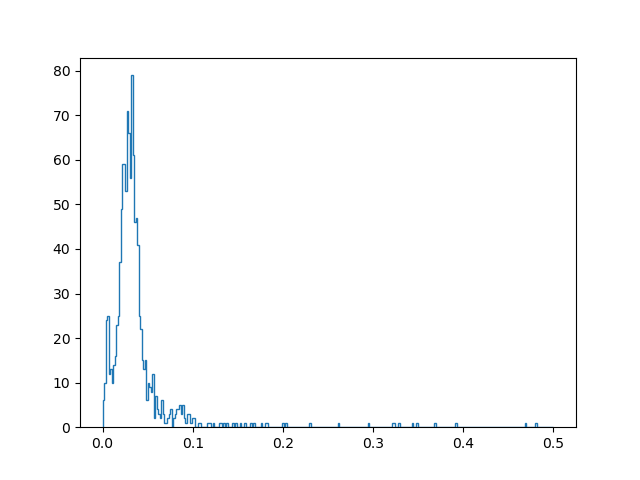

In [376]:
display(data)
plt.figure()
# for pmt in data.pmt.unique():
    # if (pmt <= 50 and pmt >= 49):
    # plt.hist(data[data.pmt == pmt].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = pmt);


# plt.hist(data[data.pmt == 0].pe_int, bins = np.arange(0, 300, 1), histtype = "step",  label = "PMT 12");
plt.hist(data[data.pmt == 1].pe_int, bins = np.linspace(0, 0.5, 300), histtype = "step",  label = "PMT 13");
# plt.hist(data[data.pmt == 2].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = "PMT 14");
# plt.hist(data[data.pmt == 3].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = "PMT 15");
# plt.hist(data[data.pmt == 4].pe_int, bins = np.arange(0, 300, 1), histtype = "step");
# plt.hist(data[data.pmt == 10].pe_int, bins = np.arange(0, 300, 2), histtype = "step");




# plt.legend()

,event,pe_int
0,47630,0.560846
1,47637,2.801355
2,47644,2.681937
3,47651,0.610834
4,47658,1.108119
5,47665,1.551085
6,47672,2.711762
7,47679,2.921606
8,47686,2.951029
9,47693,0.524843


,event,peak_time_bin,pe_int,bkg
0,47630,1650,8.164835,0.560846
1,47630,1700,6.034736,0.560846
2,47630,1750,2.694080,0.560846
3,47630,1800,2.884523,0.560846
4,47630,1850,1.644386,0.560846
...,...,...,...,...
697,48064,2050,0.575411,1.987357
698,48064,2100,0.410741,1.987357
699,48064,2150,0.249402,1.987357
700,48064,2200,0.280127,1.987357


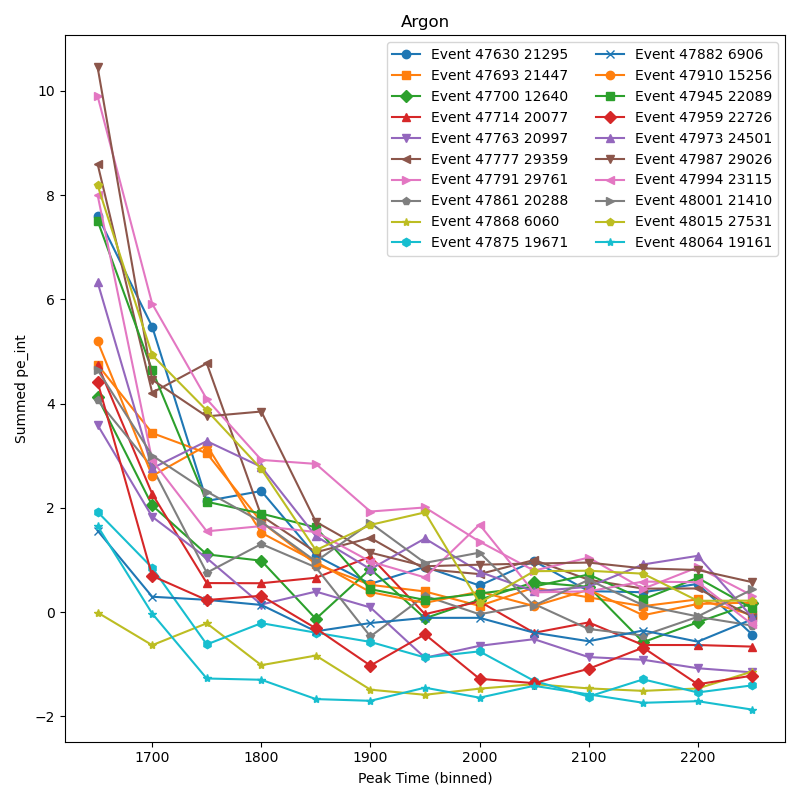

In [389]:
# Plot the PE charge vs time in the window
import itertools
marker_cycle = itertools.cycle(['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'x'])


# 1. Group by 'event' and sum 'pe_int' for each event
# summed_pe_int = data.groupby('event')['pe_int'].sum()

# 1. Define bins for peak_time from 1350 to 1770 in steps of 10
bins = np.arange(grass_lim[0], grass_lim[1], 50)  # Bins from 1350 to 1770 with step of 10
data['peak_time_bin'] = pd.cut(data['peak_time'], bins, include_lowest=True, labels=bins[:-1])

# 2. Group by 'event' and 'peak_time_bin', then sum 'pe_int'
grouped = data.groupby(['event', 'peak_time_bin'])['pe_int'].sum().reset_index()

grouped_noise = noise_df.groupby(['event'])['pe_int'].sum().reset_index()
display(grouped_noise)

grouped_noise = grouped_noise.rename(columns={'pe_int': 'bkg'})


grouped = grouped.merge(grouped_noise, on='event', how='left')

display(grouped)

# 3. Plot each event as a separate curve
plt.figure(figsize = (8,8))

for index, event in enumerate(grouped['event'].unique()):
    event_data = grouped[grouped['event'] == event]
    S2_pulse = data_properties[data_properties['event'] == event]
    S2_area = S2_pulse.S2_area.iloc[0]

    if (S2_area < 3000):
        continue

    # if (index >10):
    #     continue

    if (S2_pulse.grass_peaks.iloc[0]>0):
        continue

    # Clean up events where the noise subtraction is too large
    if (grouped_noise[grouped_noise.event == event].bkg.iloc[0] > 2):
        continue

    # print(event, event_data['pe_int'].astype(float).sum()/1e6)
    # print(event, event_data[ (event_data["peak_time_bin"]>2000) & ((event_data["peak_time_bin"]<2100))]['pe_int'].astype(float).sum()/1e6)

    marker = next(marker_cycle)
    plt.plot(event_data['peak_time_bin'].astype(float), (event_data['pe_int'] - event_data['bkg']), marker=marker, linestyle='-', label=f'Event {event} {int(S2_area)}')
    # plt.plot(event_data['peak_time_bin'], event_data['pe_int']/S2_pulse.S2_area.item(), marker='o', linestyle='-', label=f'Event {event}')

# 4. Customize plot
plt.xlabel('Peak Time (binned)')
plt.ylabel('Summed pe_int')
plt.title('Argon')
# plt.xticks(bins, rotation=45)
# plt.grid(True)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()





In [269]:
# Plot the PE charge vs time in the window
import itertools
marker_cycle = itertools.cycle(['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'x'])

# 1. Define bins for peak_time from 1350 to 1770 in steps of 10
bins = np.arange(0,150, 50)
noise_df['peak_time_bin'] = pd.cut(noise_df['peak_time'], bins, include_lowest=True, labels=bins[:-1])

# 2. Group by 'event' and 'peak_time_bin', then sum 'pe_int'
grouped = noise_df.groupby(['event'])['pe_int'].sum().reset_index()

display(grouped)

# 3. Plot each event as a separate curve
# plt.figure(figsize = (8,8))

# for index, event in enumerate(grouped['event'].unique()):
#     event_data = grouped[grouped['event'] == event]
#     S2_pulse = data_properties[data_properties['event'] == event]
#     S2_area = S2_pulse.S2_area.iloc[0]

#     if (S2_area < 3000):
#         continue

#     # if (index >10):
#     #     continue

#     marker = next(marker_cycle)
#     plt.plot(event_data['peak_time_bin'].astype(float), event_data['pe_int']/S2_area, marker=marker, linestyle='-', label=f'Event {event} {int(S2_area)}')
#     # plt.plot(event_data['peak_time_bin'], event_data['pe_int']/S2_pulse.S2_area.item(), marker='o', linestyle='-', label=f'Event {event}')

# # 4. Customize plot
# plt.xlabel('Peak Time (binned)')
# plt.ylabel('Summed pe_int')
# plt.title('Argon')
# # plt.xticks(bins, rotation=45)
# # plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()





,event,pe_int
0,27760,0.070505
1,27767,-0.015291
2,27774,0.157498
3,27781,0.192401
4,27788,0.032264
...,...,...
73,28292,0.189798
74,28299,0.296846
75,28306,0.062988
76,28313,0.150869
